# Build Model

### Import Libraries

In [1]:
import pandas as pd 
from matplotlib import image
from matplotlib import pyplot as plt
from math import cos, asin, sqrt, pi, atan2, log, exp
import numpy as np
import torch
import torch.utils.data as data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

### Move To CUDA

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Mounting Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
rel_loc="drive/MyDrive/FYP/MyFolder/CRF-2/Part-2/"

### Loading Prepared Data

1. Loading Data CSV

In [5]:
dataset = pd.read_csv(rel_loc+"part_1_output/final_prepared_dataset.csv") 
datasetdf=pd.DataFrame(dataset)
datasetdf.head()

,startX_in_meters,startY_in_meters,velocity_value_1,velocity_value_2,velocity_value_3,velocity_value_4,velocity_value_5,velocity_value_6,velocity_value_7,velocity_value_8,...,state_11,state_12,state_13,state_14,state_15,state_16,state_17,state_18,state_19,state_20
0,86.878209,216.274132,1.608839,0.448801,0.265213,0.072890,0.000000,0.072421,2.113376,0.826399,...,23,23,23,23,23,23,23,23,23,23
1,87.313688,216.385327,0.448801,0.265213,0.072890,0.000000,0.072421,2.113376,0.826399,0.069784,...,23,23,23,23,23,23,23,23,23,23
2,87.168528,216.162941,0.265213,0.072890,0.000000,0.072421,2.113376,0.826399,0.069784,0.102970,...,23,23,23,23,23,23,23,23,23,23
3,87.241094,216.162941,0.072890,0.000000,0.072421,2.113376,0.826399,0.069784,0.102970,0.000000,...,23,23,23,23,23,23,23,23,23,23
4,87.241094,216.162941,0.000000,0.072421,2.113376,0.826399,0.069784,0.102970,0.000000,0.108577,...,23,23,23,23,23,23,23,23,23,23


2. Load Floorplan Graph Dataset

In [6]:
graph = pd.read_csv(rel_loc+"part_1_output/floor_plan_graph.csv") 
graphdf=pd.DataFrame(graph)
graphdf.head()

,nodeid,x_dir_pixels,y_dir_pixels,x_dir_meters,y_dir_meters,reachable_1,reachable_2,connected_graph_id
0,0,392,285,156.8,114.0,28,24,G1
1,1,283,353,113.2,141.2,22,21,G1
2,2,445,357,178.0,142.8,24,3,G1
3,3,447,442,178.8,176.8,19,12,G1
4,4,280,270,112.0,108.0,29,18,G1


In [7]:
graph_dict=graphdf.T.to_dict().values()
print(graph_dict)

dict_values([{'nodeid': 0, 'x_dir_pixels': 392, 'y_dir_pixels': 285, 'x_dir_meters': 156.8, 'y_dir_meters': 114.0, 'reachable_1': 28, 'reachable_2': 24, 'connected_graph_id': 'G1'}, {'nodeid': 1, 'x_dir_pixels': 283, 'y_dir_pixels': 353, 'x_dir_meters': 113.2, 'y_dir_meters': 141.2, 'reachable_1': 22, 'reachable_2': 21, 'connected_graph_id': 'G1'}, {'nodeid': 2, 'x_dir_pixels': 445, 'y_dir_pixels': 357, 'x_dir_meters': 178.0, 'y_dir_meters': 142.8, 'reachable_1': 24, 'reachable_2': 3, 'connected_graph_id': 'G1'}, {'nodeid': 3, 'x_dir_pixels': 447, 'y_dir_pixels': 442, 'x_dir_meters': 178.8, 'y_dir_meters': 176.8, 'reachable_1': 19, 'reachable_2': 12, 'connected_graph_id': 'G1'}, {'nodeid': 4, 'x_dir_pixels': 280, 'y_dir_pixels': 270, 'x_dir_meters': 112.0, 'y_dir_meters': 108.0, 'reachable_1': 29, 'reachable_2': 18, 'connected_graph_id': 'G1'}, {'nodeid': 5, 'x_dir_pixels': 308, 'y_dir_pixels': 228, 'x_dir_meters': 123.2, 'y_dir_meters': 91.2, 'reachable_1': 26, 'reachable_2': 29, 'con

Calculate Start State

In [8]:
def calcNearestState(x_in_meters,y_in_meters):
    currentNearestStateID=None
    minDistance=float('inf')
    
    for points in graph_dict:
        
        stateid=points["nodeid"]
        val1=points['y_dir_pixels']/2.5-y_in_meters
        val1*=val1
        val2=points['x_dir_pixels']/2.5-x_in_meters
        val2*=val2
        val3=val1+val2
        distanceToState=val3
        
        if distanceToState<=minDistance:
            minDistance=distanceToState
            currentNearestStateID=stateid
    return currentNearestStateID

In [9]:
datasetdf.insert(2,"start_state",datasetdf.apply(lambda row: calcNearestState(row['startX_in_meters'],row['startY_in_meters']) , axis=1))
datasetdf.head()

,startX_in_meters,startY_in_meters,start_state,velocity_value_1,velocity_value_2,velocity_value_3,velocity_value_4,velocity_value_5,velocity_value_6,velocity_value_7,...,state_11,state_12,state_13,state_14,state_15,state_16,state_17,state_18,state_19,state_20
0,86.878209,216.274132,23,1.608839,0.448801,0.265213,0.072890,0.000000,0.072421,2.113376,...,23,23,23,23,23,23,23,23,23,23
1,87.313688,216.385327,23,0.448801,0.265213,0.072890,0.000000,0.072421,2.113376,0.826399,...,23,23,23,23,23,23,23,23,23,23
2,87.168528,216.162941,23,0.265213,0.072890,0.000000,0.072421,2.113376,0.826399,0.069784,...,23,23,23,23,23,23,23,23,23,23
3,87.241094,216.162941,23,0.072890,0.000000,0.072421,2.113376,0.826399,0.069784,0.102970,...,23,23,23,23,23,23,23,23,23,23
4,87.241094,216.162941,23,0.000000,0.072421,2.113376,0.826399,0.069784,0.102970,0.000000,...,23,23,23,23,23,23,23,23,23,23


3. Floorplan Graph Image

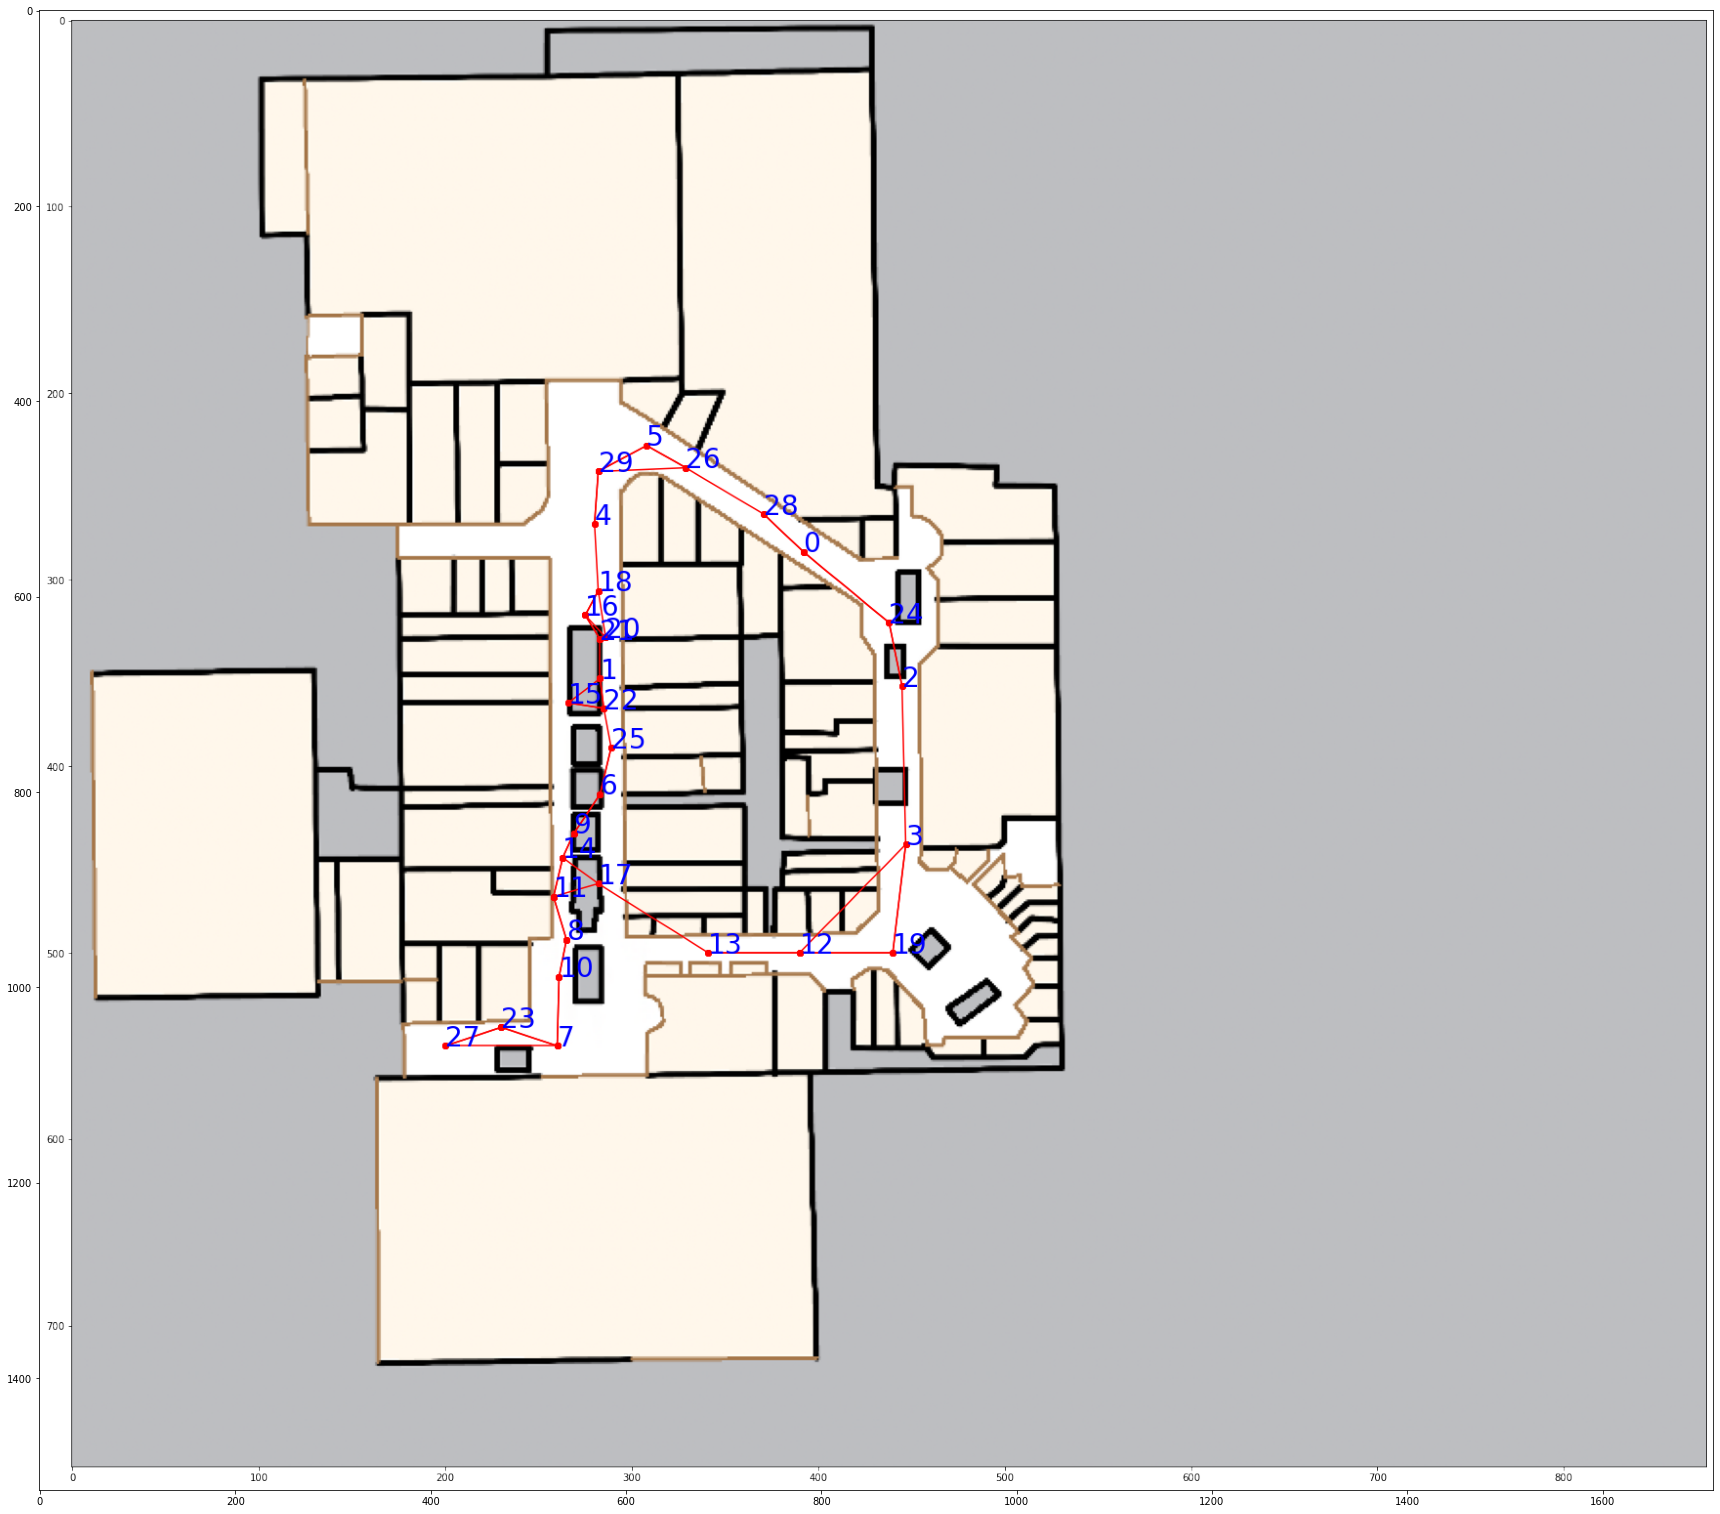

In [10]:
floorplan = image.imread(rel_loc+'part_1_output/floor_plan_graph.png')
plt.figure(figsize = (30,30))
plt.imshow(floorplan)
plt.show()

### Prepare Train Test Set

Split inputs and targets

In [11]:
inputsdf=datasetdf.iloc[:,0:43]
inputsdf.head()

,startX_in_meters,startY_in_meters,start_state,velocity_value_1,velocity_value_2,velocity_value_3,velocity_value_4,velocity_value_5,velocity_value_6,velocity_value_7,...,velocity_angle_11,velocity_angle_12,velocity_angle_13,velocity_angle_14,velocity_angle_15,velocity_angle_16,velocity_angle_17,velocity_angle_18,velocity_angle_19,velocity_angle_20
0,86.878209,216.274132,23,1.608839,0.448801,0.265213,0.072890,0.000000,0.072421,2.113376,...,0.000000,-0.992564,0.000000,0.297340,0.000000,0.000000,0.365807,0.0,0.0,0.000000
1,87.313688,216.385327,23,0.448801,0.265213,0.072890,0.000000,0.072421,2.113376,0.826399,...,-0.992564,0.000000,0.297340,0.000000,0.000000,0.365807,0.000000,0.0,0.0,0.000000
2,87.168528,216.162941,23,0.265213,0.072890,0.000000,0.072421,2.113376,0.826399,0.069784,...,0.000000,0.297340,0.000000,0.000000,0.365807,0.000000,0.000000,0.0,0.0,0.000000
3,87.241094,216.162941,23,0.072890,0.000000,0.072421,2.113376,0.826399,0.069784,0.102970,...,0.297340,0.000000,0.000000,0.365807,0.000000,0.000000,0.000000,0.0,0.0,0.000000
4,87.241094,216.162941,23,0.000000,0.072421,2.113376,0.826399,0.069784,0.102970,0.000000,...,0.000000,0.000000,0.365807,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-0.992525


In [12]:
targetsdf=datasetdf.iloc[:,43:]
targetsdf.head()

,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,state_9,state_10,state_11,state_12,state_13,state_14,state_15,state_16,state_17,state_18,state_19,state_20
0,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
1,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
2,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
3,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
4,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23


In [13]:
inputs=inputsdf.to_numpy()[:125]
print(inputs.shape)
inputs

(125, 43)


array([[ 86.87820864, 216.27413156,  23.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 87.31368835, 216.38532722,  23.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 87.1685279 , 216.16294125,  23.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [110.75700349, 151.22510585,  22.        , ...,   0.36578523,
          0.        ,   0.36582612],
       [110.46668192, 149.22358237,  22.        , ...,   0.        ,
          0.36582612,   0.47211116],
       [110.17636208, 146.99969886,  15.        , ...,   0.36582612,
          0.47211116,   0.        ]])

In [14]:
targets=targetsdf.to_numpy()[:125]
print(targets.shape)
targets

(125, 20)


array([[23, 23, 23, ..., 23, 23, 23],
       [23, 23, 23, ..., 23, 23, 23],
       [23, 23, 23, ..., 23, 23, 23],
       ...,
       [22, 22, 15, ...,  1,  1,  1],
       [22, 15, 15, ...,  1,  1, 22],
       [15, 15, 15, ...,  1, 22, 22]])

Convert To Tensor

In [15]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
print(inputs)
print(targets)

tensor([[ 86.8782, 216.2741,  23.0000,  ...,   0.0000,   0.0000,   0.0000],
        [ 87.3137, 216.3853,  23.0000,  ...,   0.0000,   0.0000,   0.0000],
        [ 87.1685, 216.1629,  23.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [110.7570, 151.2251,  22.0000,  ...,   0.3658,   0.0000,   0.3658],
        [110.4667, 149.2236,  22.0000,  ...,   0.0000,   0.3658,   0.4721],
        [110.1764, 146.9997,  15.0000,  ...,   0.3658,   0.4721,   0.0000]],
       dtype=torch.float64)
tensor([[23, 23, 23,  ..., 23, 23, 23],
        [23, 23, 23,  ..., 23, 23, 23],
        [23, 23, 23,  ..., 23, 23, 23],
        ...,
        [22, 22, 15,  ...,  1,  1,  1],
        [22, 15, 15,  ...,  1,  1, 22],
        [15, 15, 15,  ...,  1, 22, 22]])


In [16]:
ds = TensorDataset(inputs, targets)
ds[0:3]

(tensor([[ 8.6878e+01,  2.1627e+02,  2.3000e+01,  1.6088e+00,  4.4880e-01,
           2.6521e-01,  7.2890e-02,  0.0000e+00,  7.2421e-02,  2.1134e+00,
           8.2640e-01,  6.9784e-02,  1.0297e-01,  0.0000e+00,  1.0858e-01,
           1.2667e-01,  4.1078e-01,  4.3377e-01,  4.8899e-01,  5.7149e-01,
           2.8022e-01,  5.1010e-01,  7.6066e-02,  3.8021e-01,  2.5000e-01,
          -2.1491e+00,  0.0000e+00,  0.0000e+00,  3.1416e+00,  2.0338e+00,
          -1.5708e+00,  3.1416e+00, -1.5708e+00,  0.0000e+00, -9.9256e-01,
           0.0000e+00,  2.9734e-01,  0.0000e+00,  0.0000e+00,  3.6581e-01,
           0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 8.7314e+01,  2.1639e+02,  2.3000e+01,  4.4880e-01,  2.6521e-01,
           7.2890e-02,  0.0000e+00,  7.2421e-02,  2.1134e+00,  8.2640e-01,
           6.9784e-02,  1.0297e-01,  0.0000e+00,  1.0858e-01,  1.2667e-01,
           4.1078e-01,  4.3377e-01,  4.8899e-01,  5.7149e-01,  2.8022e-01,
           5.1010e-01,  7.6066e-02,  2.1347e-01,  

Split Train Test Set Randomly

In [17]:
# Random split
train_set_size = int(len(ds) * 0.8)
val_set_size = len(ds) - train_set_size
train_set, val_set = data.random_split(ds, [train_set_size, val_set_size])

Train DataLoader

In [18]:
batch_size = 5
train_dl = DataLoader(train_set, batch_size, drop_last=True, shuffle=True)
len(train_dl)

20

Test DataLoader

In [19]:
batch_size = 5
val_dl = DataLoader(val_set, batch_size, drop_last=True, shuffle=True)
len(val_dl)

5

In [20]:
sequence_length=20

In [21]:
for data,label in train_dl:
    print("Input Shape (Batch Size, Len of Seq.) : "+str(data.shape))
    print("Output Shape (Batch Size, No of Output States.) : "+str(label.shape))
    break

Input Shape (Batch Size, Len of Seq.) : torch.Size([5, 43])
Output Shape (Batch Size, No of Output States.) : torch.Size([5, 20])


### Loss Function

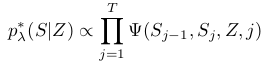

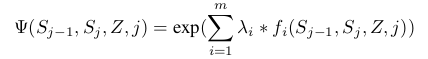

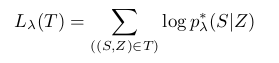

### Define Model Class

In [22]:
class Model(torch.nn.Module):
    def __init__(self,batch_size,sequence_length,graph_df,std_of_velocity_values,std_of_velocity_angles):
        
        super().__init__()
        self.batch_size=batch_size
        self.sequence_length=sequence_length
        self.graph_df=graph_df
        self.std_of_velocity_values=std_of_velocity_values
        self.std_of_velocity_angles=std_of_velocity_angles
        
        self.w1 = torch.nn.Parameter(torch.randn(()))
        self.w2 = torch.nn.Parameter(torch.randn(()))
        self.b  = torch.nn.Parameter(torch.randn(()))
        
    
    def forward(self, start_state_id, velocity_value_sequence, velocity_angle_sequence):
        
        
        argmaxes=[]
        deltas=[]
        
        for b in range(self.batch_size):
            argmaxes.append({"0_"+str(int(start_state_id[b].item())):int(start_state_id[b].item())})
            deltas.append({"0_"+str(int(start_state_id[b].item())):torch.tensor(1).to(device)})
            
        
        # Viterbi Forward
        for t in range(self.sequence_length):
            maxVal,argmaxes,deltas = self.viterbi_block(t,argmaxes,deltas,start_state_id,velocity_value_sequence[:,t],velocity_angle_sequence[:,t])
     
        # Viterbi Backward
        states_decoded=[]
        deltas_decoded=[]
        for b in range(self.batch_size):
            list_of_calculations=[] # t , state , argmax, delta
            for key in argmaxes[b].keys():
                sublist_of_calculations=[]
                sublist_of_calculations.append(int(key.split("_")[0]))
                sublist_of_calculations.append(int(key.split("_")[1]))
                sublist_of_calculations.append(argmaxes[b][key])
                sublist_of_calculations.append(deltas[b][key])
                list_of_calculations.append(sublist_of_calculations)
            
            n=self.sequence_length
            num_n_th=[[a,b,c,d] for a,b,c,d in list_of_calculations if a==n]
            num_n_th.sort(key=lambda x: x[3],reverse=True)
            y_n_latest=num_n_th[0][1]
            delta_latest=num_n_th[0][3]
            y_n=[y_n_latest]
            delta=[delta_latest]
            
            while n>1 :
                n=n-1
                y_n_latest_row=[[a,b,c,d] for a,b,c,d in list_of_calculations if a==n+1 and b==y_n_latest]
                y_n_latest=y_n_latest_row[0][2]
                delta_latest=y_n_latest_row[0][3]
                y_n.append(y_n_latest)
                delta.append(delta_latest)
            states_decoded.append(y_n)
            deltas_decoded.append(delta)
        
        deltaSum=[]
        for b in range(self.batch_size):
            sum_of_seq=torch.tensor(0).to(device)
            for t in range(self.sequence_length):
                sum_of_seq=sum_of_seq.add(deltas_decoded[b][t])
            deltaSum.append(sum_of_seq)
        return torch.tensor(states_decoded).to(device)
    
    
    def viterbi_block(self,t,argmaxes,deltas,start_state_id,velocity_value_at_t,velocity_angle_at_t):
        
        
        
        for b in range(len(argmaxes)):
            maxVal,argmaxes[b],deltas[b] = self.ViterbiRecursion(t+1,start_state_id[b],velocity_value_at_t[b],velocity_angle_at_t[b],argmaxes[b],deltas[b])

        return maxVal,argmaxes,deltas
        
    def ViterbiRecursion(self, i, state_id_tensor,velocity_value_at_t,velocity_angle_at_t,argmaxes,deltas):
    
        
        if i==0:
            return torch.tensor(1).to(device),"",""
        else:
            maxval=-float('inf')
            argmax=None
            state_id=state_id_tensor.item()
            state_id_from_row=self.graph_df[self.graph_df["nodeid"]==state_id]
            reachables = (state_id_from_row["reachable_1"].values[0],state_id_from_row["reachable_2"].values[0], state_id)

            for j in reachables:


                key=str(int(i))+"_"+str(int(j))
                if key in deltas.keys():
                    val1 = deltas[key]
                else:
                    val1,temp1,temp2 = self.ViterbiRecursion(i-1, torch.tensor(j).to(device),velocity_value_at_t,velocity_angle_at_t,argmaxes,deltas)

                velocity_value_at_t_tensor=torch.tensor([velocity_value_at_t]).to(device)
                velocity_angle_at_t_tensor=torch.tensor([velocity_angle_at_t]).to(device)
                state_id_t_tensor=torch.tensor([state_id]).to(device)
                state_id_t_minus_1_tensor=torch.tensor([j]).to(device)
                val2 = self.sigh_block(velocity_value_at_t_tensor,velocity_angle_at_t_tensor,state_id_t_tensor,state_id_t_minus_1_tensor)
                
                
                val=val1+val2[0]
        
                if(val>maxval):
                    maxval=val
                    argmax=j
            deltas[str(int(i))+"_"+str(int(state_id))]=maxval
            argmaxes[str(int(i))+"_"+str(int(state_id))]=argmax

            return maxval,argmaxes,deltas
    
    def calcNearestState(self,x_in_meters,y_in_meters):
       
        results=[]
        
        for i in range(len(x_in_meters)):
            
            currentNearestStateID=None
            minDistance=float('inf')

            for row in self.graph_df.to_dict('records'):

                stateid=row["nodeid"]
                val1=row['y_dir_meters']-y_in_meters[i]
                val1*=val1
                val2=row['x_dir_meters']-x_in_meters[i]
                val2*=val2
                val3=val1+val2
                distanceToState=sqrt(val3)

                if distanceToState<=minDistance:
                    minDistance=distanceToState
                    currentNearestStateID=stateid
            results.append(currentNearestStateID)
            
        return torch.tensor(results).to(device)
    
    def isReachable(self,state_id_from,state_id_to):
        
        results=[]
        
        for i in range(len(state_id_from)):
            
            state_id_from_row=self.graph_df[self.graph_df["nodeid"]==state_id_from[i].item()]
            reachables = (str(state_id_from_row["reachable_1"].values[0]),str(state_id_from_row["reachable_2"].values[0]), str(state_id_from[i].item()))

            if str(state_id_to[i].item()) in reachables:
                results.append(1)
            else:
                results.append(0)
        
        return torch.tensor(results).to(device)
    
    
    def f1(self,velocity_value_at_t_tensor,state_id_t_tensor,state_id_t_minus_1_tensor):
        
        results=[]
        
        for i in range(len(velocity_value_at_t_tensor)):
            velocity_value_at_t = velocity_value_at_t_tensor[i].item()
            state_id_t = state_id_t_tensor[i].item()
            state_id_t_minus_1 = state_id_t_minus_1_tensor[i].item()
        
        
            state_t=self.graph_df[self.graph_df["nodeid"]==state_id_t]
            state_t_minus_1=self.graph_df[self.graph_df["nodeid"]==state_id_t_minus_1]
            x2,y2=state_t["x_dir_meters"].values[0],state_t["y_dir_meters"].values[0]
            x1,y1=state_t_minus_1["x_dir_meters"].values[0],state_t_minus_1["y_dir_meters"].values[0]
    
            euc_dis=sqrt((y2-y1)**2+(x2-x1)**2)
    
            val= log(1/(self.std_of_velocity_values*sqrt(2*pi)))-((velocity_value_at_t-euc_dis)**2/(2*(self.std_of_velocity_values**2)))
    
            results.append(val)
        
        return torch.tensor(results).to(device) * self.isReachable(state_id_t_tensor,state_id_t_minus_1_tensor)
    
    
    
    
    def f2(self,velocity_angle_at_t_tensor,state_id_t_tensor,state_id_t_minus_1_tensor):
        
        
        
        results=[]
        
        for i in range(len(velocity_angle_at_t_tensor)):
            velocity_angle_at_t = velocity_angle_at_t_tensor[i].item()
            state_id_t = state_id_t_tensor[i].item()
            state_id_t_minus_1 = state_id_t_minus_1_tensor[i].item()
        
        
            state_t=self.graph_df[self.graph_df["nodeid"]==state_id_t]
            state_t_minus_1=self.graph_df[self.graph_df["nodeid"]==state_id_t_minus_1]
            x2,y2=state_t["x_dir_meters"].values[0],state_t["y_dir_meters"].values[0]
            x1,y1=state_t_minus_1["x_dir_meters"].values[0],state_t_minus_1["y_dir_meters"].values[0]
    
            orientation=atan2(y2-y1,x2-x1)
    
            val= log(1/(self.std_of_velocity_angles*sqrt(2*pi)))-((velocity_angle_at_t-orientation)**2/(2*(self.std_of_velocity_angles**2)))
    
            results.append(val)
        
        return torch.tensor(results).to(device) * self.isReachable(state_id_t_tensor,state_id_t_minus_1_tensor)
    
    
    def sigh_block(self,velocity_value_at_t_tensor,velocity_angle_at_t_tensor,state_id_t_tensor,state_id_t_minus_1_tensor):
        
        f1_calc=self.f1(velocity_value_at_t_tensor,state_id_t_tensor,state_id_t_minus_1_tensor)
        f2_calc=self.f2(velocity_angle_at_t_tensor,state_id_t_tensor,state_id_t_minus_1_tensor)
        
        return self.w1*f1_calc+ self.w2*f2_calc+self.b
    
    def check(self):
        print("w1 : "+str(self.w1.grad.item()))
        print("w2 : "+str(self.w2.grad.item()))
        print("b : "+str(self.b.grad.item()))
        
    def evaluate(self,pred,yb):
        
        correct = 0
        total = 0
        
        for b in range(self.batch_size):
            for i in range(sequence_length):
                total=total+1
                if int(pred[b][i])==int(yb[b][i]):
                    correct=correct+1
        
        return correct/total
        
        
        
        
    def custom_loss(self,velocityseq, angleseq, pred):

        psz=torch.tensor([1.0]).to(device)

        for t in range(1,self.sequence_length):
          sigh = self.sigh_block( velocityseq[:,t], angleseq[:,t], pred[:,t], pred[:,t-1])
          psz=psz+sigh
          
        return psz
    

In [24]:
def std(list1):
    return torch.std(list1)

all_velocity_values=train_set[:][0][:,3:23]
all_velocity_angles=train_set[:][0][:,23:]
std_of_all_velocity_values=std(all_velocity_values)
std_of_all_velocity_angles=std(all_velocity_angles)

In [25]:
model = Model(batch_size,sequence_length,graphdf,std_of_all_velocity_values,std_of_all_velocity_angles)
model.to(device)

Model()

Calculate std

### Training

In [26]:
num_epochs=10
loss_fn=model.custom_loss
opt = torch.optim.SGD(model.parameters(), lr=0.05)
print(list(model.parameters()))

[Parameter containing:
tensor(-1.5314, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.2846, device='cuda:0', requires_grad=True), Parameter containing:
tensor(-0.7406, device='cuda:0', requires_grad=True)]


In [30]:
# Utility function to train the model
def fit(num_epochs, model, loss_fn, opt, train_dl, val_dl):
    
    # Repeat for given number of epochs
    for epoch in range(num_epochs):
        
        batch_train_accuracies=[]
        batch_train_losses=[]
        batch_train_no=0
        
        # Train with batches of data
        for xb,yb in train_dl:
            
            xb = xb.to(device)
            yb = yb.to(device)

            batch_train_no=batch_train_no+1
            
            # 1. Generate predictions
            starts=xb[:,2]
            velocityseq=xb[:,3:23]
            angleseq=xb[:,23:] 
            
            pred = model(starts,velocityseq,angleseq)
            
            # 2. Calculate loss
            train_loss = torch.mean(loss_fn(velocityseq, angleseq, pred))
            batch_train_losses.append(train_loss.item())
            
            # 3. Compute gradients
            train_loss.backward()            
            
            # 4. Update parameters using gradients
            opt.step()            
            
            # 5. Reset the gradients to zero
            opt.zero_grad()
            
            # 6. Calculate Batch Accuracies
            train_acc_i=model.evaluate(pred,yb)
            batch_train_accuracies.append(train_acc_i)
            
            # Print Progress
            print(' -    Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, num_epochs,batch_train_no,len(train_dl), train_loss.item(), train_acc_i))
            
        
        
        batch_val_accuracies=[]
        batch_val_losses=[]

        # Run Model Over Validation Set
        for xb,yb in val_dl:
            
            xb = xb.to(device)
            yb = yb.to(device)
            
            # 1. Generate predictions
            starts=xb[:,2]
            velocityseq=xb[:,3:23]
            angleseq=xb[:,23:] 
            
            pred = model(starts,velocityseq,angleseq)
            
            # 2. Calculate loss
            val_loss = torch.mean(loss_fn(velocityseq, angleseq, pred))
            batch_val_losses.append(val_loss.item())
            
            # 3. Calculate Validation Accuracies
            val_acc_i=model.evaluate(pred,yb)
            batch_val_accuracies.append(val_acc_i)

        # Print Progress
        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.4f}'.format(epoch+1, num_epochs , sum(batch_train_losses)/len(batch_train_losses), sum(batch_train_accuracies)/len(batch_train_accuracies), sum(batch_val_losses)/len(batch_val_losses), sum(batch_val_accuracies)/len(batch_val_accuracies)))


In [ ]:
fit(num_epochs, model, loss_fn, opt, train_dl, val_dl)